In [1]:
%pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [1]:
import graphviz
from graphviz import Digraph
from IPython.display import Image

In [2]:
import pandas as pd
import datetime as dtm
import numpy as np
from typing import Callable, Union, Any, Optional
from abc import ABC, abstractmethod

import sigtech.framework as sig

env = sig.init()

SigTech environment successfully initialized


## Node Classes

In [3]:
class Node(ABC):
    @abstractmethod
    def evaluate(self, context):
        pass

class DecisionNode(Node):
    def __init__(
        self, 
        indicator: dict, 
        window: int, 
        operator: str, 
        threshold: Union[float, Callable[[dict], float]], 
        true_branch: Node, 
        false_branch: Node
    ):
        """
        Initializes a DecisionNode.

        :param indicator: Dictionary with 'name' and 'etf' keys.
        :param window: Window size for the indicator.
        :param operator: Comparison operator as a string ('>', '<', '>=', '<=', '==').
        :param threshold: Static float value or a callable that returns a float based on context.
        :param true_branch: Node to evaluate if condition is True.
        :param false_branch: Node to evaluate if condition is False.
        """
        self.indicator = indicator  # e.g., {'name': 'RSI', 'etf': 'QQQ UP EQUITY'}
        self.window = window
        self.operator = operator
        self.threshold = threshold  # Can be a float or a callable
        self.true_branch = true_branch
        self.false_branch = false_branch

    def evaluate(self, context):
        """
        Evaluates the condition and traverses the tree accordingly.

        :param context: Dictionary containing necessary data and parameters.
        :return: Result from the true or false branch.
        """
        if callable(self.threshold):
            threshold_value = self.threshold(context)
            print(f"[DecisionNode] Evaluating condition: {self.get_label()} with dynamic threshold {threshold_value}")
        else:
            threshold_value = self.threshold
            print(f"[DecisionNode] Evaluating condition: {self.get_label()} with threshold {threshold_value}")

        # Retrieve the indicator value from context
        indicator_value = get_indicator_value(context, self.indicator, self.window)
        print(f"[DecisionNode] Indicator Value for {self.indicator['etf']}: {indicator_value}")

        # Perform the comparison
        condition_met = self.compare(indicator_value, self.operator, threshold_value)
        print(f"[DecisionNode] Condition Met: {condition_met}")

        if condition_met:
            return self.true_branch.evaluate(context)
            print(f"[DecisionNode] Condition true. Traversing to True branch.")
        else:
            return self.false_branch.evaluate(context)
            print(f"[DecisionNode] Condition false. Traversing to False branch.")

    def compare(self, value1, operator, value2):
        """
        Compares two values based on the operator.

        :param value1: First value (indicator value).
        :param operator: Comparison operator as a string.
        :param value2: Second value (threshold).
        :return: Boolean result of the comparison.
        """
        if operator == '>':
            return value1 > value2
        elif operator == '<':
            return value1 < value2
        elif operator == '>=':
            return value1 >= value2
        elif operator == '<=':
            return value1 <= value2
        elif operator == '==':
            return value1 == value2
        else:
            raise ValueError(f"Unsupported operator: {operator}")

    def get_label(self):
        """
        Generates a descriptive label for the condition.

        :return: String label.
        """
        if callable(self.threshold):
            threshold_desc = self.threshold.__name__
        else:
            threshold_desc = self.threshold
        return f"{self.indicator['name']}({self.indicator['etf']}, {self.window}) {self.operator} {threshold_desc}"



class ActionNode(Node):
    def __init__(self, allocations: dict):
        """
        Initializes an ActionNode.

        :param allocations: Dictionary mapping ETFs to their allocation weights (in decimal).
                            e.g., {'SPY UP EQUITY': 0.5, 'TLT US EQUITY': 0.5}
        """
        self.allocations = allocations  # e.g., {'SPY UP EQUITY': 0.5, 'TLT US EQUITY': 0.5}

    def evaluate(self, context):
        """
        Executes the action by allocating the specified weights to ETFs.

        :param context: Dictionary containing necessary data and parameters.
        :return: Dictionary representing the order allocations.
        """
        print(f"[ActionNode] Executing action: {self.get_label()}")
        return self.action(context)

    def action(self, context):
        """
        Calculates the order allocations based on the allocations and ETF prices.

        :param context: Dictionary containing ETF histories and other parameters.
        :return: Dictionary with ETF orders.
        """
        allocations = {
            etf: self.allocations[etf] * context['initial_cash'] / context['etf_histories'][etf].asof(context['size_date']) 
            for etf in self.allocations
        }
        print(f"[ActionNode] Allocations: {allocations}")
        return allocations

    def get_label(self):
        """
        Generates a descriptive label for the action.

        :return: String label.
        """
        allocations_str = ', '.join([f"{etf}: {weight*100:.1f}%" for etf, weight in self.allocations.items()])
        return f"Allocate {allocations_str}"


rendering function

In [4]:
def plot_tree(root_node):
    """
    Plots the decision tree using graphviz.

    :param root_node: The root node of the decision tree.
    :return: graphviz.Digraph object.
    """
    dot = Digraph(comment='Decision Tree')
    node_counter = [0]  # Mutable counter

    def traverse(node, parent_id=None, edge_label=''):
        node_id = str(node_counter[0])
        node_counter[0] += 1

        if isinstance(node, DecisionNode):
            label = node.get_label()
            dot.node(node_id, label, shape='diamond')
            traverse(node.true_branch, node_id, 'True')
            traverse(node.false_branch, node_id, 'False')
        elif isinstance(node, ActionNode):
            label = node.get_label()
            dot.node(node_id, label, shape='box')
        else:
            dot.node(node_id, 'Unknown', shape='ellipse')

        if parent_id is not None:
            dot.edge(parent_id, node_id, label=edge_label)

    traverse(root_node)
    return dot

## Function Definitions

In [5]:
def get_rsi(data, window):
    delta = data.diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    avg_gain = up.ewm(com=window - 1, adjust=True).mean()
    avg_loss = down.ewm(com=window - 1, adjust=True).mean()
    rs = avg_gain / avg_loss
    rsi_series = 100 - (100 / (1 + rs))
    return rsi_series

def get_vol(data, window):
    returns = data.pct_change()
    return returns.rolling(window).std()

def get_cum_return(data, window):
    returns = data.pct_change()
    cumulative_returns = (returns + 1).rolling(window).apply(lambda x: x.prod(), raw=True) - 1
    return cumulative_returns.iloc[-1] if len(cumulative_returns) >= window else 0

def allocate_values(default_keys, allocations=None):
    """
    Allocates values to keys in a dictionary. Keys without specific allocations are set to 0.

    :param default_keys: List of keys that should be present in the dictionary.
    :param allocations: Dictionary of keys with their allocated values. If None, all keys will be set to 0.
    :return: Dictionary with allocated values.
    """
    # Initialize the dictionary with 0 for all keys
    result = {key: 0 for key in default_keys}
    
    # If allocations are provided, update the dictionary with those values
    if allocations:
        for key, value in allocations.items():
            
            if key in result:
                result[key] = value
    
    return result

def compare_cumulative_returns(context):
    """
    Computes the cumulative return of BND UP EQUITY and BIL UP EQUITY and returns BIL UP EQUITY's cumulative return as the threshold.

    :param context: Dictionary containing ETF histories and other parameters.
    :return: Cumulative return of BIL UP EQUITY.
    """
    cumul_bnd = get_cum_return(context['etf_histories']['BND UP EQUITY'].loc[:context['midnight_dt']], 60)
    cumul_bil = get_cum_return(context['etf_histories']['BIL UP EQUITY'].loc[:context['midnight_dt']], 60)
    return cumul_bil  # The threshold is BIL UP EQUITY's cumulative return



def get_indicator_value(context, indicator: dict, window: int) -> float:
    """
    Retrieves the indicator value from the ETF history.

    :param context: Dictionary containing ETF histories and other parameters.
    :param indicator: Dictionary with 'name' and 'etf' keys.
    :param window: Window size for the indicator (if applicable).
    :return: Indicator value.
    """
    etf = indicator['etf']
    name = indicator['name']
    
    if name.lower() == 'rsi':
        return get_rsi(context['etf_histories'][etf], window).loc[context['midnight_dt']]
    elif name.lower() == 'volatility':
        return get_vol(context['etf_histories'][etf], window).loc[context['midnight_dt']]
    elif name.lower() == 'cumulative return':
        return get_cum_return(context['etf_histories'][etf].loc[:context['midnight_dt']], window)
    else:
        raise ValueError(f"Unsupported indicator: {name}")


## Condition Functions

In [6]:
def condition1(context):
    rsi_series = get_rsi(context['etf_histories']['QQQ UP EQUITY'], 20)
    midnight_dt = context['midnight_dt']
    if midnight_dt not in rsi_series.index:
        return False
    rsi_value = rsi_series.loc[midnight_dt]
    return rsi_value > 70

def condition2(context):
    vol_series = get_vol(context['etf_histories']['VIXY US EQUITY'], 11)
    midnight_dt = context['midnight_dt']
    if midnight_dt not in vol_series.index:
        return False
    vol_value = vol_series.loc[midnight_dt]
    return vol_value > 0.025

def condition2a(context):
    cumul_bnd = get_cum_return(context['etf_histories']['BND UP EQUITY'].loc[:context['midnight_dt']], 60)
    cumul_bil = get_cum_return(context['etf_histories']['BIL UP EQUITY'].loc[:context['midnight_dt']], 60)
    return cumul_bnd > cumul_bil

def condition3(context):
    rsi_series = get_rsi(context['etf_histories']['QQQ UP EQUITY'], 31)
    midnight_dt = context['midnight_dt']
    if midnight_dt not in rsi_series.index:
        return False
    rsi_value = rsi_series.loc[midnight_dt]
    return rsi_value < 10

## Action Functions

## Build the Decision Tree

In [11]:
# Leaf nodes (actions)
action_node1 = ActionNode(allocations={'SPY UP EQUITY': 0.5, 'TLT US EQUITY': 0.5})
action_node2a = ActionNode(allocations={'TQQQ US EQUITY': 1.0})
action_node2b = ActionNode(allocations={'SPY UP EQUITY': 0.55, 'SVXY US EQUITY': 0.225, 'TLT US EQUITY': 0.225})
action_node3 = ActionNode(allocations={'TQQQ US EQUITY': 1.0})
action_node4 = ActionNode(allocations={'BIL UP EQUITY': 0.25, 'SPY UP EQUITY': 0.25, 'TLT US EQUITY': 0.25, 'GLD UP EQUITY': 0.25})

# Decision nodes
decision_node2a = DecisionNode(
    indicator={'name': 'Cumulative Return', 'etf': 'BND UP EQUITY'},
    window=60,
    operator='>',
    threshold=compare_cumulative_returns,  # Using callable for dynamic threshold
    true_branch=action_node2a,
    false_branch=action_node2b
)

decision_node3 = DecisionNode(
    indicator={'name': 'RSI', 'etf': 'QQQ UP EQUITY'},
    window=31,
    operator='<',
    threshold=10,
    true_branch=action_node3,
    false_branch=action_node4
)

decision_node2 = DecisionNode(
    indicator={'name': 'Volatility', 'etf': 'VIXY US EQUITY'},
    window=11,
    operator='>',
    threshold=0.025,
    true_branch=decision_node2a,
    false_branch=decision_node3
)

root_node = DecisionNode(
    indicator={'name': 'RSI', 'etf': 'QQQ UP EQUITY'},
    window=20,
    operator='>',
    threshold=70,
    true_branch=action_node1,
    false_branch=decision_node2
)


In [12]:
# Initialize the decision tree
class DecisionTree:
    def __init__(self, root):
        self.root = root

    def evaluate(self, context):
        return self.root.evaluate(context)

decision_tree = DecisionTree(root_node)

## basket_creation_method

In [13]:
def basket_creation_method(strategy, dt, positions, **additional_parameters):
    verbose = False
    size_date = pd.Timestamp(strategy.size_date_from_decision_dt(dt))
    midnight_dt = dt.replace(hour=0, minute=0, second=0, microsecond=0, tzinfo=None)
    bc_params = additional_parameters
    example_dates = bc_params['example_dates']
    order = {}

    if verbose: print()
    if midnight_dt not in example_dates:
        return {}

    if verbose:
        print(f'DATE: {midnight_dt}')
        print('RSI20 ', get_rsi(etf_histories['QQQ UP EQUITY'], 20).loc[midnight_dt])
        print('VOL ', get_vol(etf_histories['VIXY US EQUITY'], 11).loc[midnight_dt])
        print('CUMUL BND', get_cum_return(etf_histories['BND UP EQUITY'].loc[:midnight_dt], 60),
              'CUMUL BIL', get_cum_return(etf_histories['BIL UP EQUITY'].loc[:midnight_dt], 60),
              'COMPARISON', get_cum_return(etf_histories['BND UP EQUITY'].loc[:midnight_dt], 60) > get_cum_return(etf_histories['BIL UP EQUITY'].loc[:midnight_dt], 60))
        print('RSI31 ', get_rsi(etf_histories['QQQ UP EQUITY'], 31).loc[midnight_dt])



    # Build the context for the decision tree
    context = {
        'strategy': strategy,
        'dt': dt,
        'positions': positions,
        'additional_parameters': additional_parameters,
        'size_date': size_date,
        'midnight_dt': midnight_dt,
        'initial_cash': strategy.initial_cash,
        'etf_histories': etf_histories,
        'etfs': etfs,
    }

    # Evaluate the decision tree
    order = decision_tree.evaluate(context)
    print(f"DEBUG -- PRE-ORDER: {order} @ {dt}")
    order = {etfs[symbol]: weight for symbol, weight in allocate_values(etfs, order).items()}
    print(f"DEBUG -- ORDER PASSED: {order} @ {dt}")
    return order

## Data Preparation

In [14]:
etfs = {
    'TLT US EQUITY' : sig.obj.get('TLT US EQUITY'), 
    'TQQQ US EQUITY': sig.obj.get('TQQQ US EQUITY'),
    'SVXY US EQUITY': sig.obj.get('SVXY US EQUITY'),
    'VIXY US EQUITY': sig.obj.get('VIXY US EQUITY'),
    'QQQ UP EQUITY' : sig.obj.get('QQQ UP EQUITY'),
    'SPY UP EQUITY' : sig.obj.get('SPY UP EQUITY'),
    'BND UP EQUITY' : sig.obj.get('BND UP EQUITY'),
    'BIL UP EQUITY' : sig.obj.get('BIL UP EQUITY'),
    'GLD UP EQUITY' : sig.obj.get('GLD UP EQUITY'),
}

etf_histories = {name: etf.history() for name, etf in etfs.items()}

START_DATE = dtm.date(2024, 6, 2)
END_DATE = dtm.date(2024, 6, 30)
INITIAL_CASH = 1e6

# Example dates from bc_params
example_dates = [
    dtm.datetime(2024, 6, 30, 14, 50, 0),
    dtm.datetime(2024, 6, 27, 0, 0, 0),
    dtm.datetime(2024, 6, 26, 0, 0, 0),
    dtm.datetime(2024, 6, 25, 0, 0, 0),
    dtm.datetime(2024, 6, 24, 0, 0, 0),
    dtm.datetime(2024, 6, 21, 0, 0, 0),
    dtm.datetime(2024, 6, 20, 0, 0, 0),
    dtm.datetime(2024, 6, 18, 0, 0, 0),
    dtm.datetime(2024, 6, 17, 0, 0, 0),
    dtm.datetime(2024, 6, 14, 0, 0, 0),
    dtm.datetime(2024, 6, 13, 0, 0, 0),
    dtm.datetime(2024, 6, 12, 0, 0, 0),
    dtm.datetime(2024, 6, 11, 0, 0, 0),
    dtm.datetime(2024, 6, 10, 0, 0, 0),
    dtm.datetime(2024, 6, 7, 0, 0, 0),
    dtm.datetime(2024, 6, 6, 0, 0, 0),
    dtm.datetime(2024, 6, 5, 0, 0, 0),
    dtm.datetime(2024, 6, 4, 0, 0, 0),
    dtm.datetime(2024, 6, 3, 0, 0, 0)
]

## Initialize sig.DynamicStrategy

In [15]:
strat = sig.DynamicStrategy(
    currency='USD',
    start_date=START_DATE,
    end_date=END_DATE,
    trade_frequency='1BD',
    basket_creation_method=basket_creation_method,
    basket_creation_kwargs={'example_dates': example_dates},
    initial_cash=INITIAL_CASH,
)

strat.build(progress=True)

  0%|                                                   | 0/100 [00:00<?, ?it/s]

[DecisionNode] Evaluating condition: RSI(QQQ UP EQUITY, 20) > 70 with threshold 70
[DecisionNode] Indicator Value for QQQ UP EQUITY: 58.8593954517936
[DecisionNode] Condition Met: False
[DecisionNode] Evaluating condition: Volatility(VIXY US EQUITY, 11) > 0.025 with threshold 0.025
[DecisionNode] Indicator Value for VIXY US EQUITY: 0.0235520369951749
[DecisionNode] Condition Met: False
[DecisionNode] Evaluating condition: RSI(QQQ UP EQUITY, 31) < 10 with threshold 10
[DecisionNode] Indicator Value for QQQ UP EQUITY: 57.71592996579445
[DecisionNode] Condition Met: False
[ActionNode] Executing action: Allocate BIL UP EQUITY: 25.0%, SPY UP EQUITY: 25.0%, TLT US EQUITY: 25.0%, GLD UP EQUITY: 25.0%
[ActionNode] Allocations: {'BIL UP EQUITY': 2734.3322760581864, 'SPY UP EQUITY': 473.6642667677151, 'TLT US EQUITY': 2729.2576419213974, 'GLD UP EQUITY': 1150.9069146487432}
DEBUG -- PRE-ORDER: {'BIL UP EQUITY': 2734.3322760581864, 'SPY UP EQUITY': 473.6642667677151, 'TLT US EQUITY': 2729.2576419

In [16]:
strat.inspect.bottom_trades_df()

dt instrument_name   display_name   trade_size  \
0  2024-06-04 20:00:00+00:00   BIL UP EQUITY  BIL UP EQUITY  2734.332276   
1  2024-06-04 20:00:00+00:00   GLD UP EQUITY  GLD UP EQUITY  1150.906915   
2  2024-06-04 20:00:00+00:00   SPY UP EQUITY  SPY UP EQUITY   473.664267   
3  2024-06-04 20:00:00+00:00   TLT US EQUITY  TLT US EQUITY  2729.257642   
4  2024-06-05 20:00:00+00:00   BIL UP EQUITY  BIL UP EQUITY    -0.597995   
5  2024-06-05 20:00:00+00:00   GLD UP EQUITY  GLD UP EQUITY    10.425366   
6  2024-06-05 20:00:00+00:00   SPY UP EQUITY  SPY UP EQUITY    -0.528893   
7  2024-06-05 20:00:00+00:00   TLT US EQUITY  TLT US EQUITY   -31.512956   
8  2024-06-06 20:00:00+00:00   BIL UP EQUITY  BIL UP EQUITY    -0.298899   
9  2024-06-06 20:00:00+00:00   GLD UP EQUITY  GLD UP EQUITY   -13.595617   
10 2024-06-06 20:00:00+00:00   SPY UP EQUITY  SPY UP EQUITY    -5.557241   
11 2024-06-06 20:00:00+00:00   TLT US EQUITY  TLT US EQUITY   -19.651488   
12 2024-06-07 20:00:00+00:00   BIL UP EQUITY  BIL UP EQUITY    -0.298834   
13 2024-06-07 20:00:00+00:00   GLD UP EQUITY  GLD UP EQUITY    -8.421164   
14 2024-06-07 20:00:00+00:00   SPY UP EQUITY  SPY UP EQUITY     0.008745   
15 2024-06-07 20:00:00+00:00   TLT US EQUITY  TLT US EQUITY     4.022455   
16 2024-06-10 20:00:00+00:00   BIL UP EQUITY  BIL UP EQUITY    -1.194683   
17 2024-06-10 20:00:00+00:00   GLD UP EQUITY  GLD UP EQUITY    42.158981   
18 2024-06-10 20:00:00+00:00   SPY UP EQUITY  SPY UP EQUITY     0.569149   
19 2024-06-10 20:00:00+00:00   TLT US EQUITY  TLT US EQUITY    50.124784   
20 2024-06-11 20:00:00+00:00   BIL UP EQUITY  BIL UP EQUITY    -0.596950   
21 2024-06-11 20:00:00+00:00   GLD UP EQUITY  GLD UP EQUITY   -10.733635   
22 2024-06-11 20:00:00+00:00   SPY UP EQUITY  SPY UP EQUITY    -1.442067   
23 2024-06-11 20:00:00+00:00   TLT US EQUITY  TLT US EQUITY    18.337184   
24 2024-06-12 20:00:00+00:00   BIL UP EQUITY  BIL UP EQUITY -2731.344914   
25 2024-06-12 20:00:00+00:00   GLD UP EQUITY  GLD UP EQUITY -1170.740845   
26 2024-06-12 20:00:00+00:00   SPY UP EQUITY  SPY UP EQUITY   464.471439   
27 2024-06-12 20:00:00+00:00   TLT US EQUITY  TLT US EQUITY  2694.266112   
28 2024-06-13 20:00:00+00:00   SPY UP EQUITY  SPY UP EQUITY    -7.585576   
29 2024-06-13 20:00:00+00:00   TLT US EQUITY  TLT US EQUITY   -40.606811   
30 2024-06-14 20:00:00+00:00   SPY UP EQUITY  SPY UP EQUITY    -1.855883   
31 2024-06-14 20:00:00+00:00   TLT US EQUITY  TLT US EQUITY   -78.288903   
32 2024-06-17 20:00:00+00:00   SPY UP EQUITY  SPY UP EQUITY    -0.560403   
33 2024-06-17 20:00:00+00:00   TLT US EQUITY  TLT US EQUITY   -44.443846   
34 2024-06-18 20:00:00+00:00   SPY UP EQUITY  SPY UP EQUITY    -7.273831   
35 2024-06-18 20:00:00+00:00   TLT US EQUITY  TLT US EQUITY    52.967182   
36 2024-06-20 20:00:00+00:00   SPY UP EQUITY  SPY UP EQUITY    -2.316058   
37 2024-06-20 20:00:00+00:00   TLT US EQUITY  TLT US EQUITY   -48.500321   
38 2024-06-21 20:00:00+00:00   BIL UP EQUITY  BIL UP EQUITY  2727.173557   
39 2024-06-21 20:00:00+00:00   GLD UP EQUITY  GLD UP EQUITY  1145.947928   
40 2024-06-21 20:00:00+00:00   SPY UP EQUITY  SPY UP EQUITY  -454.555257   
41 2024-06-21 20:00:00+00:00   TLT US EQUITY  TLT US EQUITY -2625.264349   
42 2024-06-24 20:00:00+00:00   BIL UP EQUITY  BIL UP EQUITY    -0.892205   
43 2024-06-24 20:00:00+00:00   GLD UP EQUITY  GLD UP EQUITY    18.033821   
44 2024-06-24 20:00:00+00:00   SPY UP EQUITY  SPY UP EQUITY     2.089999   
45 2024-06-25 20:00:00+00:00   BIL UP EQUITY  BIL UP EQUITY    -0.594479   
46 2024-06-25 20:00:00+00:00   GLD UP EQUITY  GLD UP EQUITY    -4.588343   
47 2024-06-25 20:00:00+00:00   SPY UP EQUITY  SPY UP EQUITY     1.497323   
48 2024-06-25 20:00:00+00:00   TLT US EQUITY  TLT US EQUITY   -10.717284   
49 2024-06-26 20:00:00+00:00   GLD UP EQUITY  GLD UP EQUITY     5.781837   
50 2024-06-26 20:00:00+00:00   SPY UP EQUITY  SPY UP EQUITY    -1.766987   
51 2024-06-26 20:00:00+00:00   TLT US EQUITY  TLT US EQUITY    -4.486755  

In [18]:
strat.plot.performance()

## Plot the tree

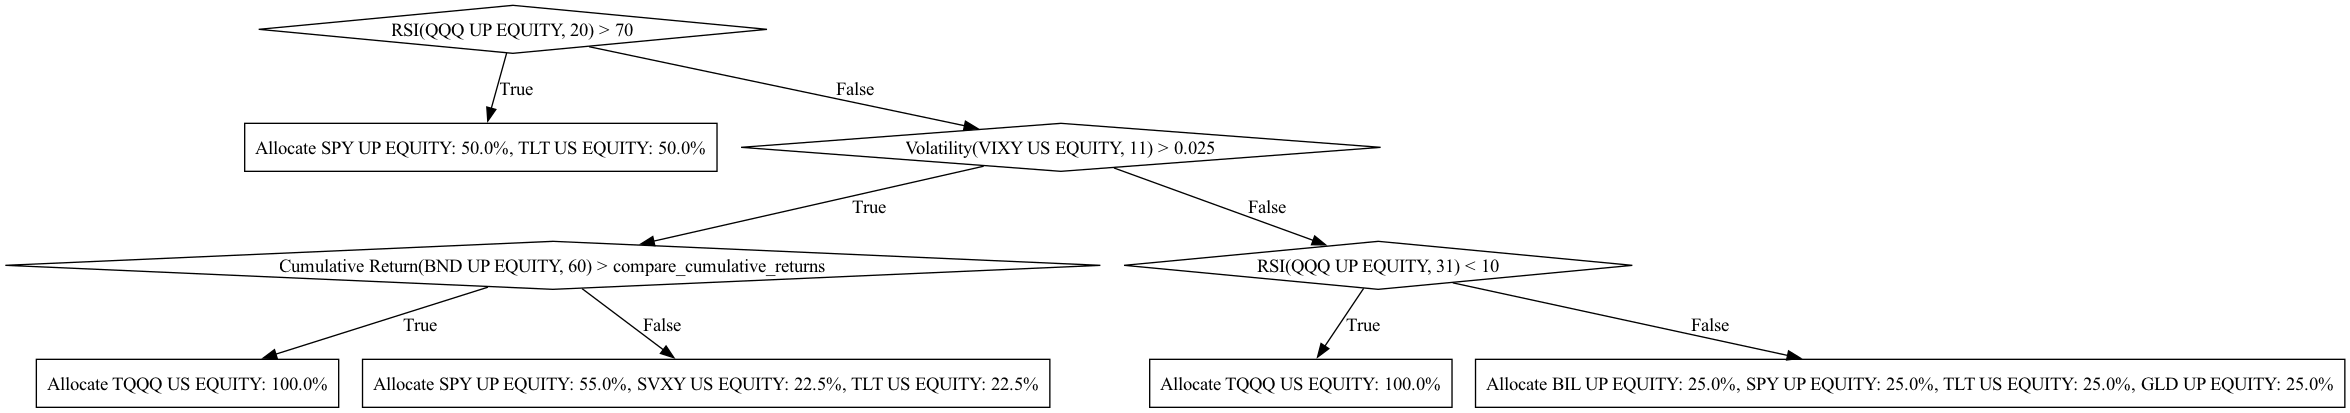

In [19]:
# Plot the tree
dot = plot_tree(root_node)

# Display the tree inline in Jupyter Notebook
dot.format = 'png'
dot.render('decision_tree', view=False)
Image(filename='decision_tree.png')

In [20]:
def print_tree(node, level=0):
    indent = "  " * level
    if isinstance(node, DecisionNode):
        print(f"{indent}Decision: {node.get_label()}")
        if node.true_branch:
            print(f"{indent}  True ->")
            print_tree(node.true_branch, level + 2)
        if node.false_branch:
            print(f"{indent}  False ->")
            print_tree(node.false_branch, level + 2)
    elif isinstance(node, ActionNode):
        print(f"{indent}Action: {node.get_label()}")
    else:
        print(f"{indent}Unknown Node")

# Print the tree
print_tree(root_node)


Decision: RSI(QQQ UP EQUITY, 20) > 70
  True ->
    Action: Allocate SPY UP EQUITY: 50.0%, TLT US EQUITY: 50.0%
  False ->
    Decision: Volatility(VIXY US EQUITY, 11) > 0.025
      True ->
        Decision: Cumulative Return(BND UP EQUITY, 60) > compare_cumulative_returns
          True ->
            Action: Allocate TQQQ US EQUITY: 100.0%
          False ->
            Action: Allocate SPY UP EQUITY: 55.0%, SVXY US EQUITY: 22.5%, TLT US EQUITY: 22.5%
      False ->
        Decision: RSI(QQQ UP EQUITY, 31) < 10
          True ->
            Action: Allocate TQQQ US EQUITY: 100.0%
          False ->
            Action: Allocate BIL UP EQUITY: 25.0%, SPY UP EQUITY: 25.0%, TLT US EQUITY: 25.0%, GLD UP EQUITY: 25.0%
